# 0.0. Imports

In [1]:
import math 
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb

import pickle
import random
import warnings
warnings.filterwarnings('ignore')

from boruta                import BorutaPy
from tabulate              import tabulate
from datetime              import date
from matplotlib            import gridspec
from IPython.display       import Image
from scipy                 import stats
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso 

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )


        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )    

    
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    
    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #for pandas to display the complete dataframe, with no restriction on the number of columns to be displayed, I can change the following option:
    pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    


### 0.2. Loading Data 

In [3]:
df_sales_raw = pd.read_csv('rossmann-store-sales/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('rossmann-store-sales/store.csv', low_memory = False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
             'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#snakecase = lambda x: x.lower()
snakecase = lambda x: inflection.underscore (x)

cols_new = list((map(snakecase,cols_old)))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of rows: {}'. format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

### 1.5.1. competition_distance   
If there is no data available, I will assume: 

1)There is no competition;

2)The closest competitor might be too far to compute. 

Filling these column with numbers way higher than the current maximum distance is a good way to represent the 2 hypothesis assumed previously.

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x) else x)

# for i in range(len(df1)):
#     if pd.isna(df1.loc[i,'competition_distance']) == True:
#         df1.loc[i,'competition_distance'] = 200000

### 1.5.2. competition_open_since_month    
Reasons for lack of data:

1)There is no competition;

2)Competition was opened but not recorded.

If data is N/A. I will copy the info in the date column into competition_open_since_month column.

In [11]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)

### 1.5.3. competition_open_since_year

In [12]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

### 1.5.4. promo2_since_week

In [13]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)

### 1.5.5. promo2_since_year               

In [14]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)

### 1.5.6. promo_interval
Replacing N/A with 0.

In [15]:
month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                      1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                      0, axis = 1 )

## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

1)Understanding the business; 

2)Finding out errors.

In [18]:
num_attributes = df1.select_dtypes( include = ('int64','float64'))
cat_attributes = df1.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
586070,366,3,6321,583,1,1,0,6470.0,12,2004,0,4,2014,0
688752,468,2,4504,539,1,1,0,5260.0,9,2012,0,43,2013,0


### 1.7.1. Numerical Attributes


In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [20]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


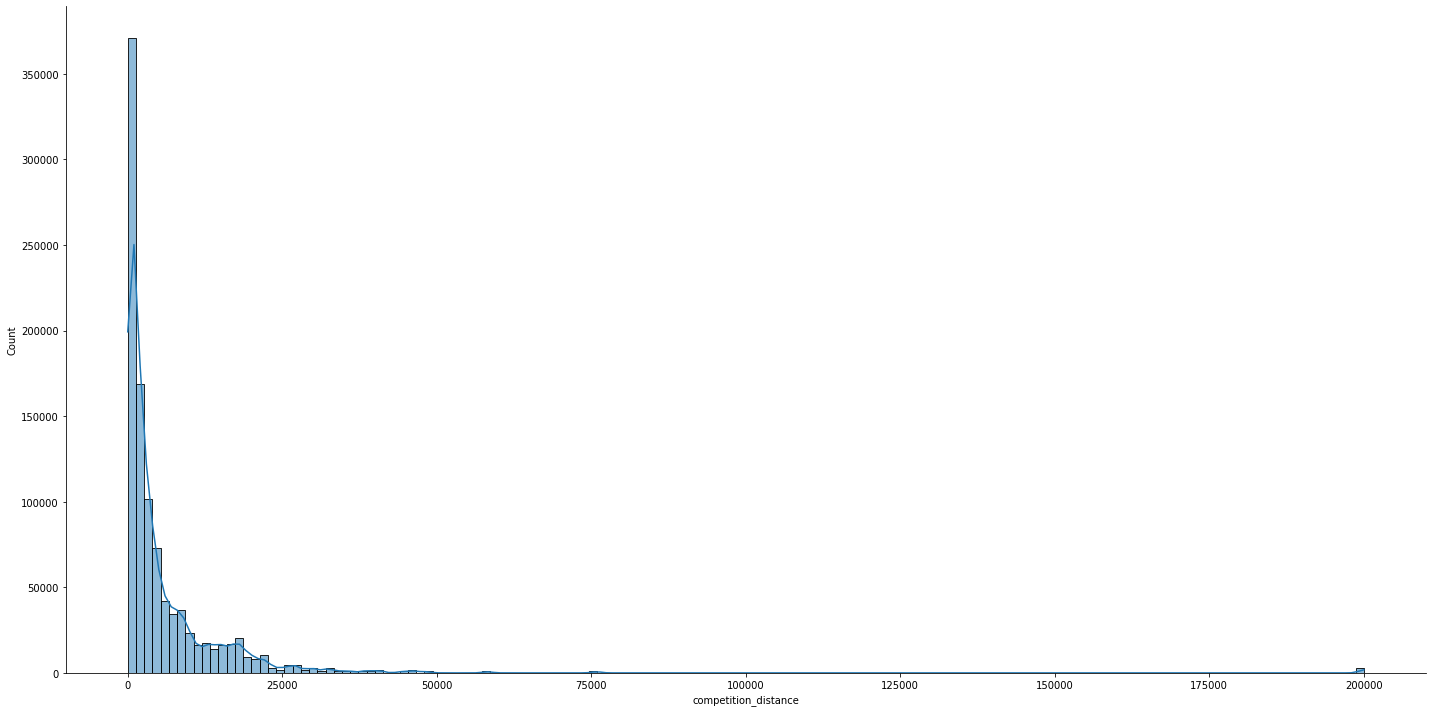

In [21]:
# sns.histplot (df1 ['sales'], kde=True, stat="density", linewidth=0, binwidth=1500)
sns.displot (df1 ['competition_distance'], kde=True, bins = 150, height = 10, aspect = 2)

### 1.7.2. Categorical Attributes


In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

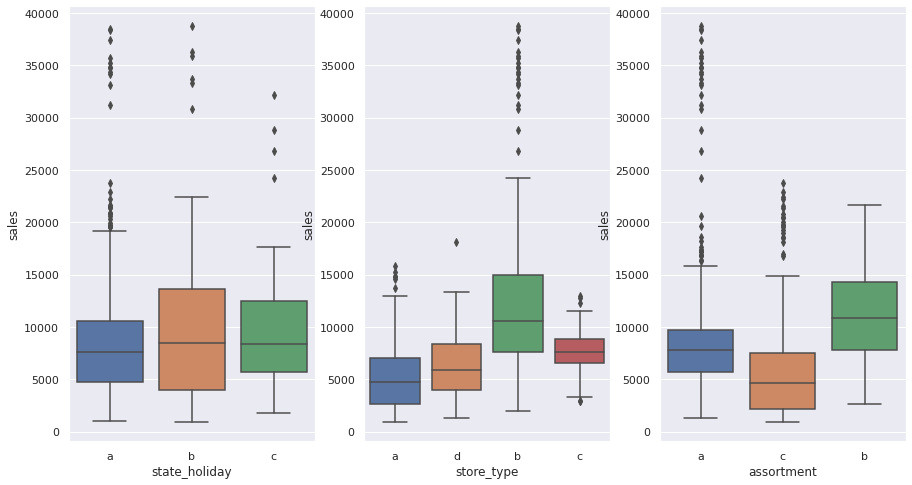

In [23]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

sns.set(rc = {'figure.figsize':(15,8)})
plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1. MindMap Hypothesis

The purpose is to understand how the attributes affect our main event (sales).


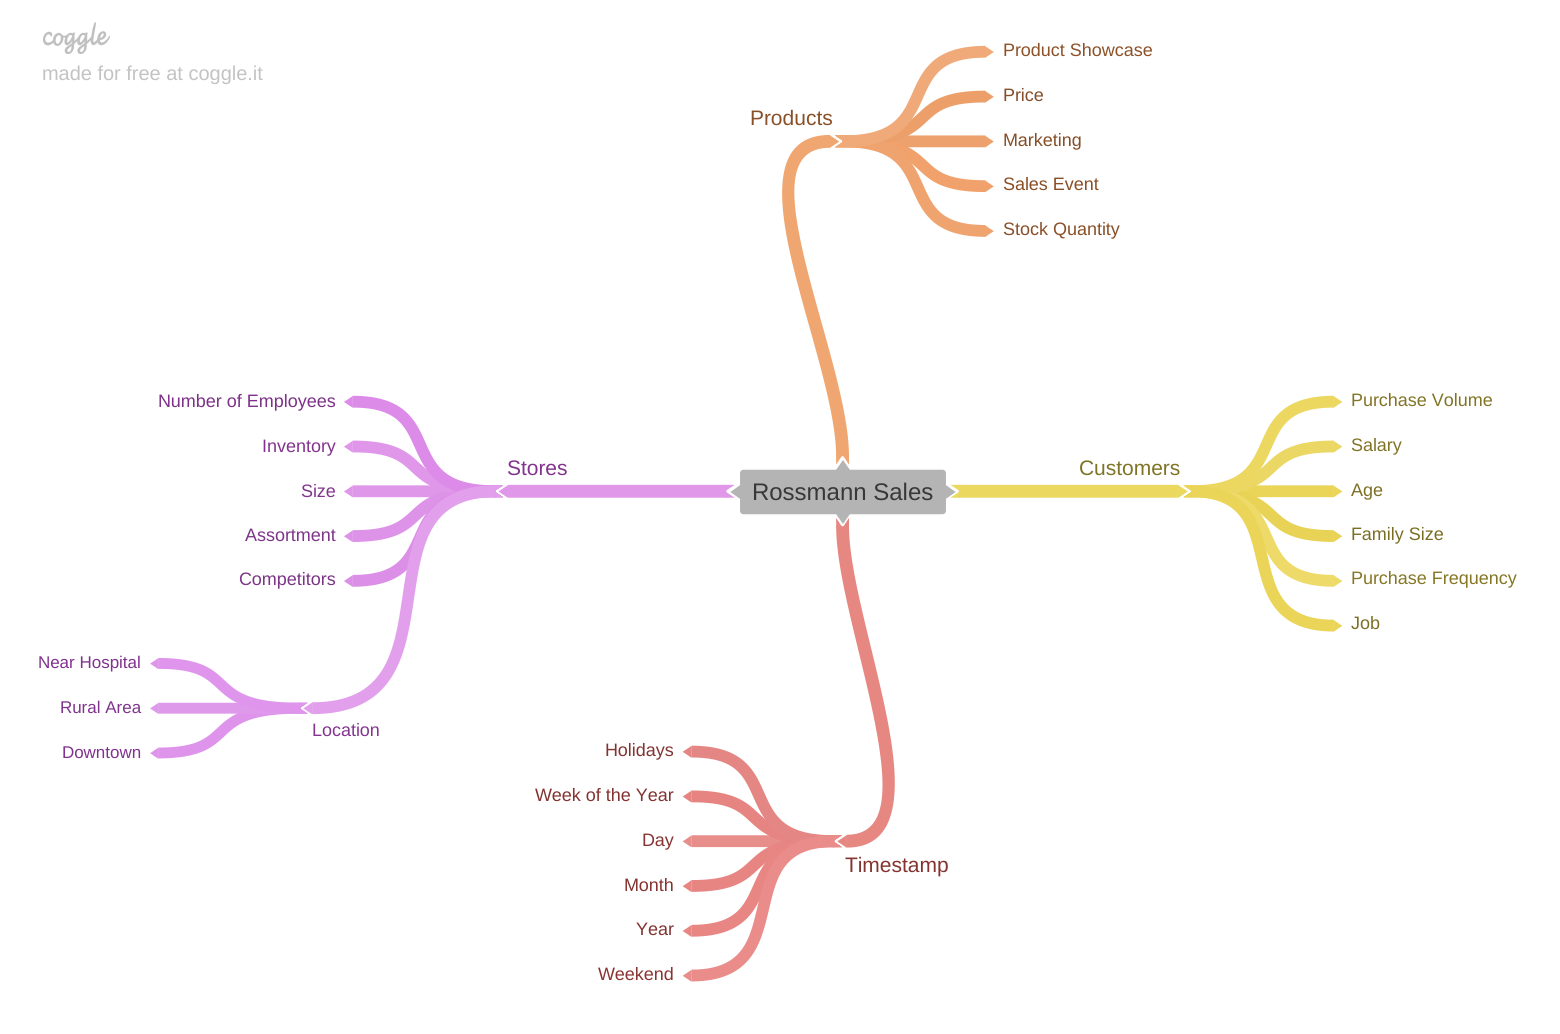

In [25]:
Image('Images/MindMap_Hypothesis.png')

## 2.1. Hyphothesis
How? Start working with hypothesis that have data available.

**H1.** Stores with more product assortment are more likely to sell more daily

**H2.** Stores with closer competitors should are more likely to sell less

**H3.** Stores with longer-standing competitors are more likely sell more

**H4.** Products on sales during a long period of time are more likely to sell more daily

**H5.** Stores with more extended promotions are more likely to sell more

**H6.** Sales are more likely to increase during holiday season (Christmas)

**H7.** Stores are more likely to sell more over the years

**H8.** Stores are more likely to sell more more in the second half of the year

**H9.** Stores are more likely to sell more after the 10th day of each month

**H10.** Stores are more likely to sell less on weekends

**H11.** Stores are more likely to sell less during school holidays

## 2.3. Feature Engineering


In [26]:
# year
df2 ['year'] = df2['date'].dt.year

# month
df2 ['month'] = df2['date'].dt.month

# day
df2 ['day'] = df2['date'].dt.day

# week of year
df2 ['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' 
                                                  else 'easter_holiday' if  x=='b'  
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

# 3.0. Filtered Variables

In [27]:
df3 = df2.copy()

## 3.1. Filtered Rows


In [28]:
# df3 = df3.loc[df3['open'] == 1]
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtered Columns


In [29]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis (EDA)

In [31]:
df4 = df3.copy()

In [32]:
num_attributes = df4.select_dtypes( include = ('int64','float64'))
cat_attributes = df4.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))


# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


## 4.1. Univariate Analysis


### 4.1.1. Response Variable


<AxesSubplot:xlabel='sales', ylabel='Count'>

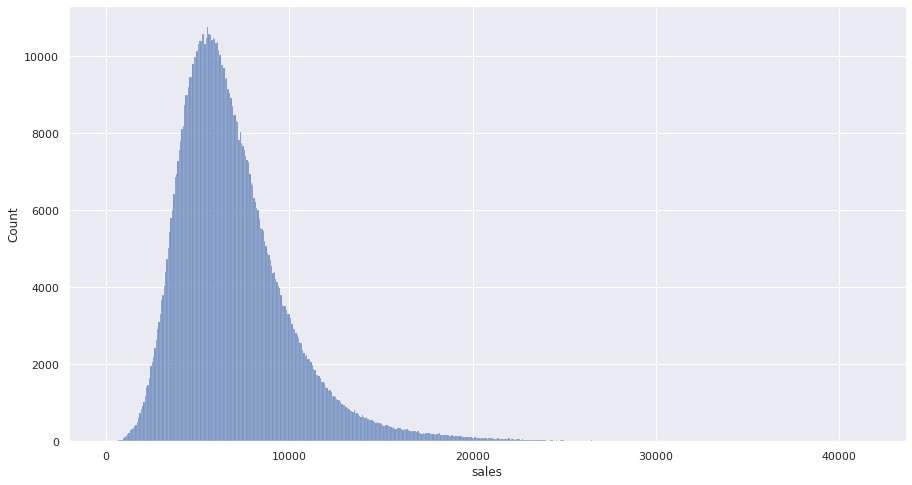

In [33]:
sns.histplot(df4['sales'])

### 4.1.2. Numerical Variable


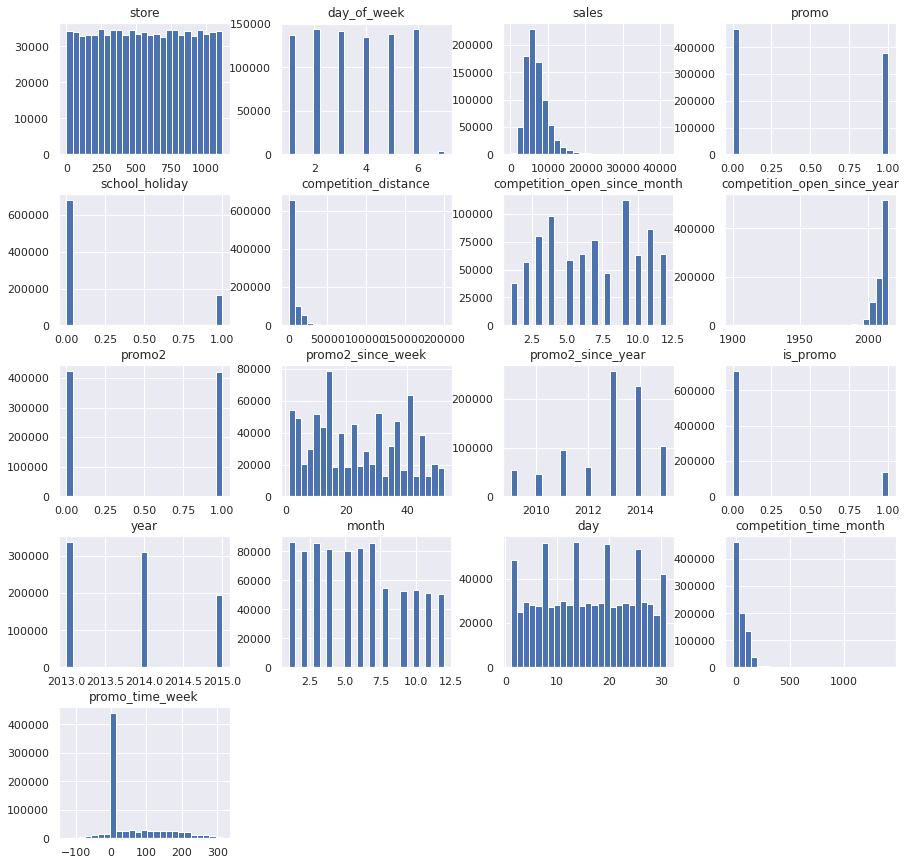

In [34]:
sns.set(rc = {'figure.figsize':(15,15)})
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable


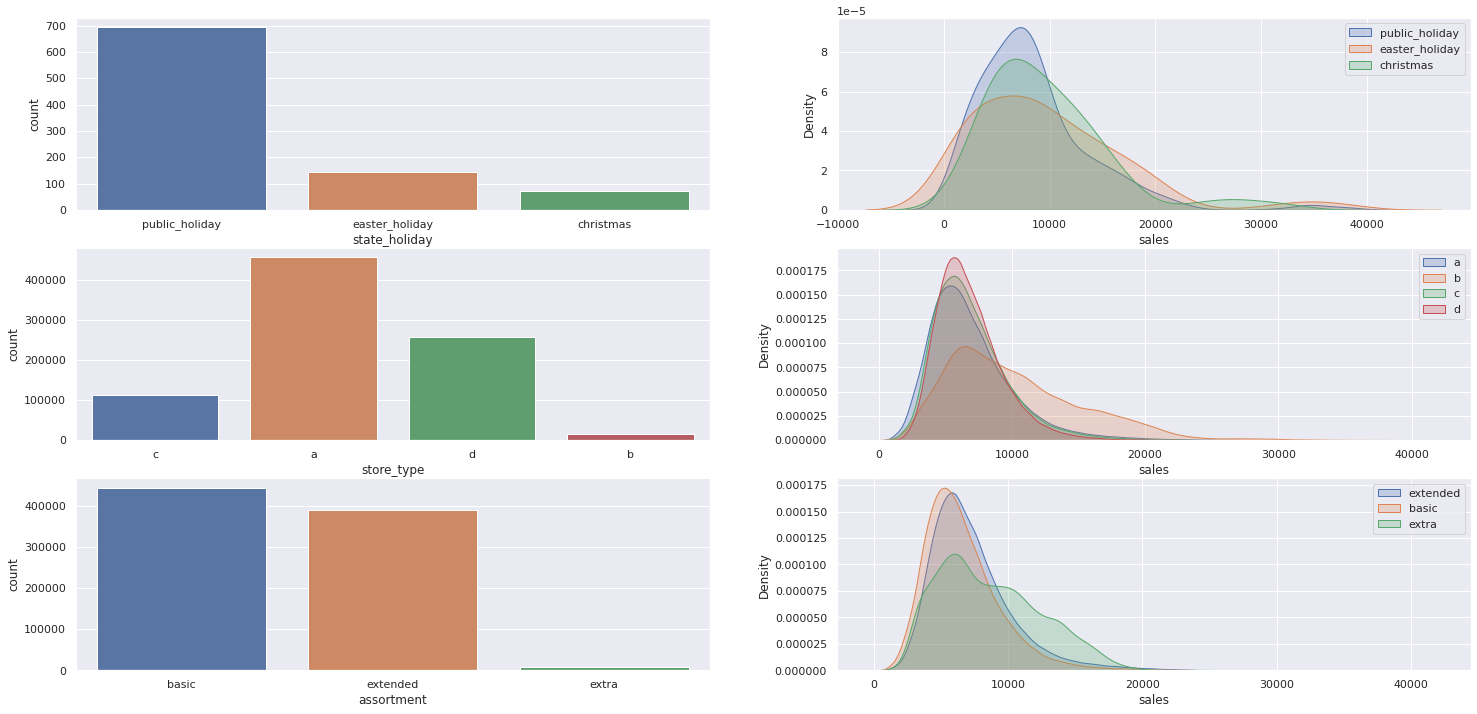

In [35]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)
plt.legend()

plt.show()

## 4.2. Bivariate Analysis


### H1. Stores with more product assortment are more likely to sell more daily

In [36]:
print(df4[df4['assortment'] == 'extra'].shape[0])
print(df4[df4['assortment'] == 'basic'].shape[0])
print(df4[df4['assortment'] == 'extended'].shape[0])

8209
444875
391254


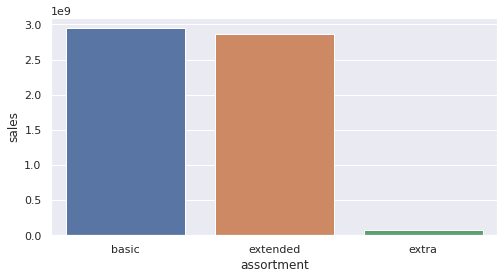

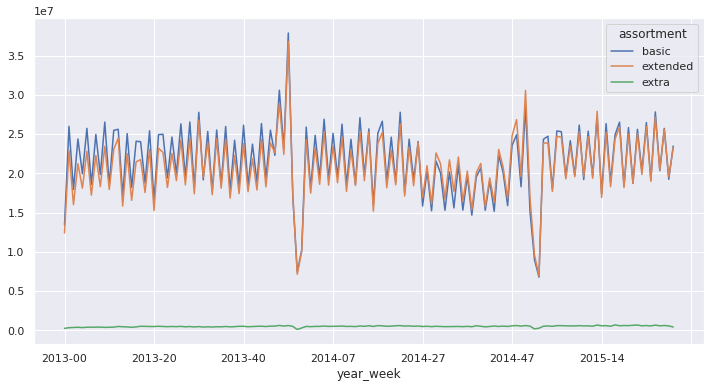

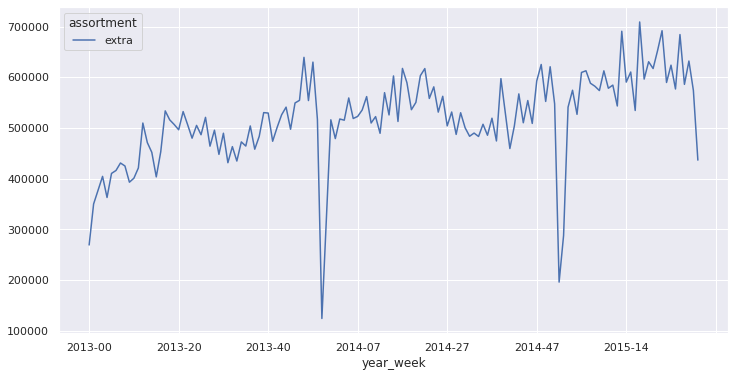

In [37]:
plt.figure(figsize=(8,4))
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(data = aux1, x='assortment', y = 'sales')

aux2 = df4[['assortment','sales','year_week']].groupby(['assortment','year_week']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment',values = 'sales').plot(figsize=(12,6))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment',values = 'sales').plot(figsize=(12,6))

plt.show()

### H2. Stores with closer competitors should are more likely to sell less

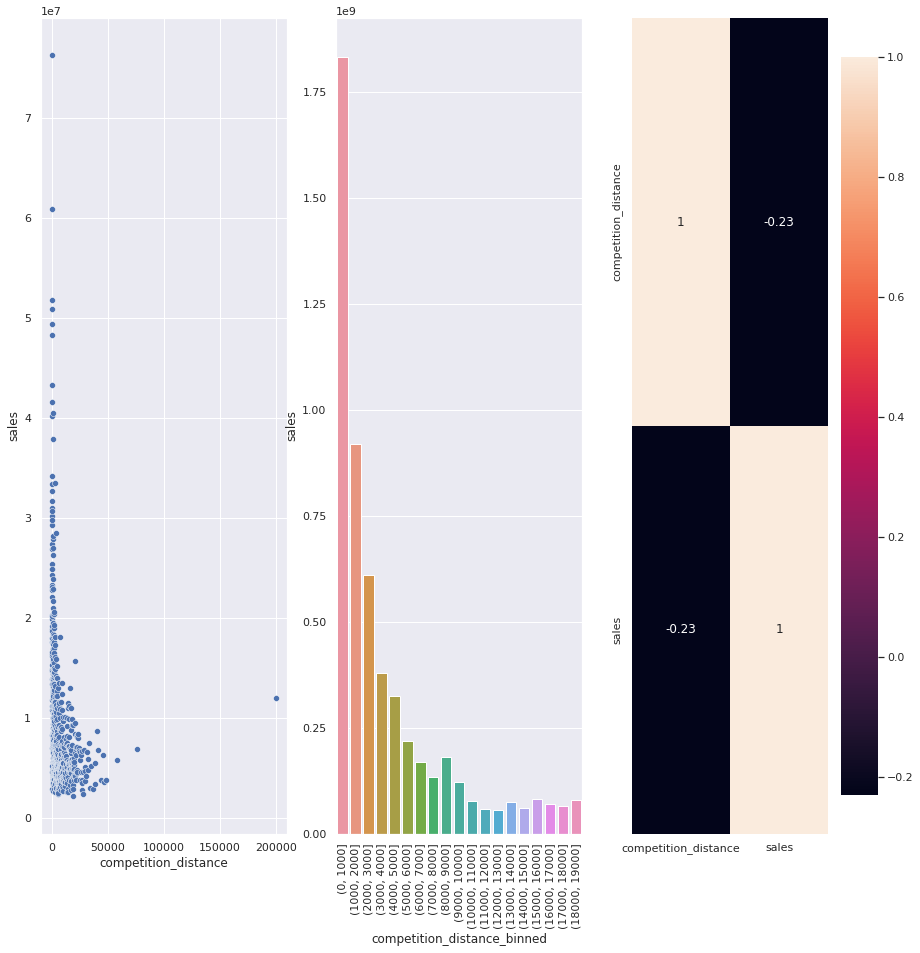

In [38]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot( x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list( np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True);

### H3.  Stores with longer-standing competitors are more likely sell more

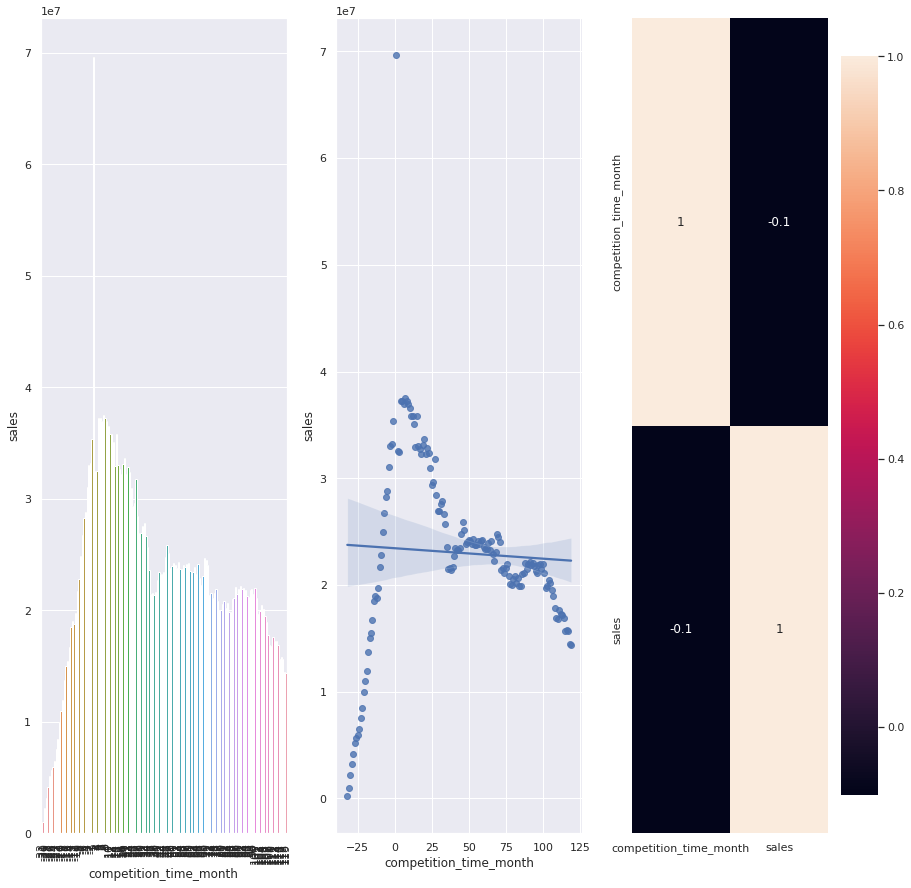

In [39]:
plt.subplot( 1,3,1 )
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation=90);

plt.subplot( 1,3,2 )
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr (method='pearson'), annot = True);

### H4. Products on sales during a long period of time are more likely to sell more daily

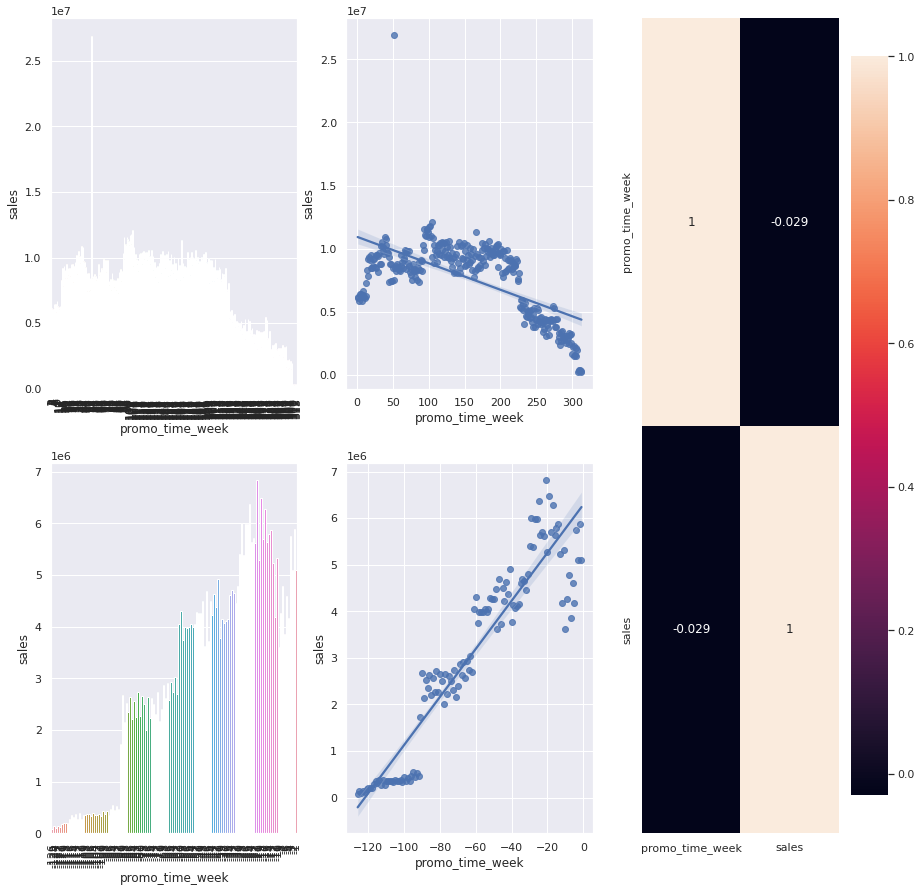

In [40]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(data=aux1, x='promo_time_week', y='sales');

grid = plt.GridSpec( 2,3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotion
sns.barplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot( grid[0,1] )
sns.regplot( x = 'promo_time_week', y='sales', data=aux2)

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
sns.barplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.subplot( grid[1,1] )
sns.regplot( x = 'promo_time_week', y='sales', data=aux3)

plt.subplot( grid[:,2] )
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H5. Stores with more extended promotions are more likely to sell more

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


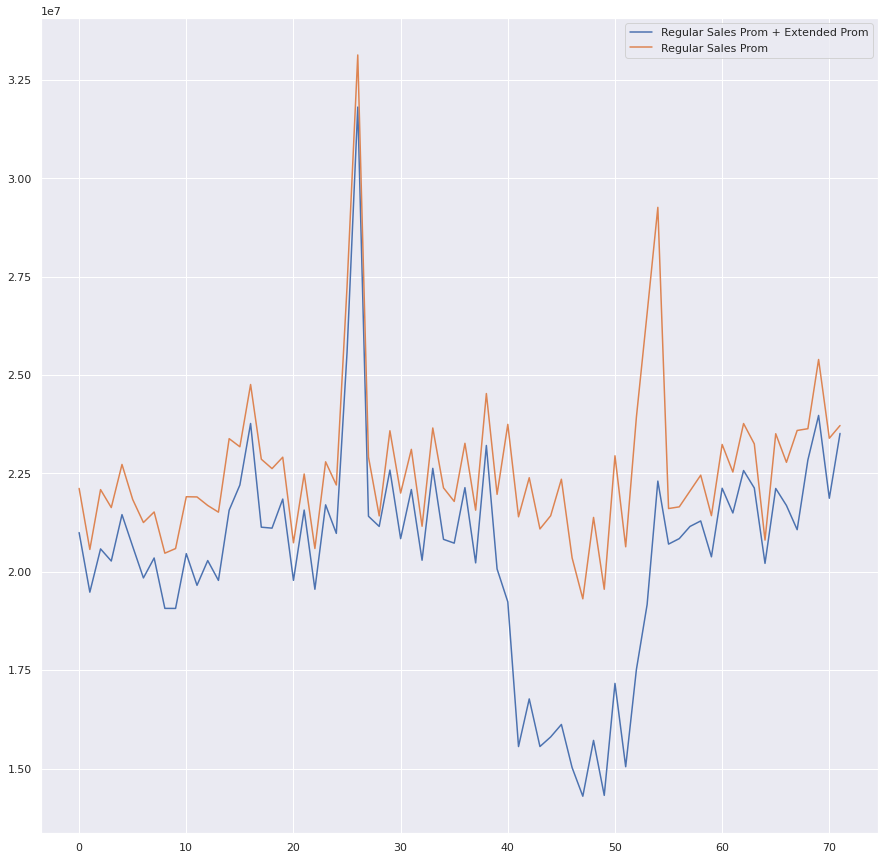

In [42]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend( labels = ['Regular Sales Prom + Extended Prom', 'Regular Sales Prom'])

### H6. Sales are more likely to increase the during holiday season (Christmas)


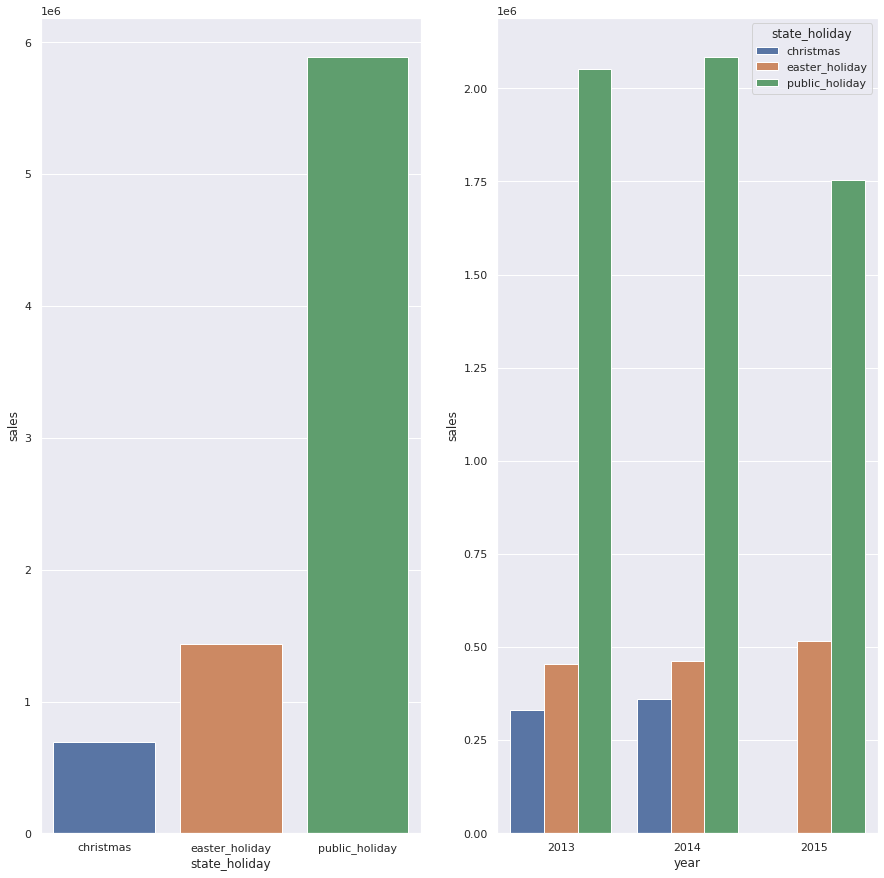

In [43]:
plt.subplot(1,2,1)
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = df4[df4['state_holiday'] != 'regular_day'][['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);



### H7. Stores are more likely to sell more over the years


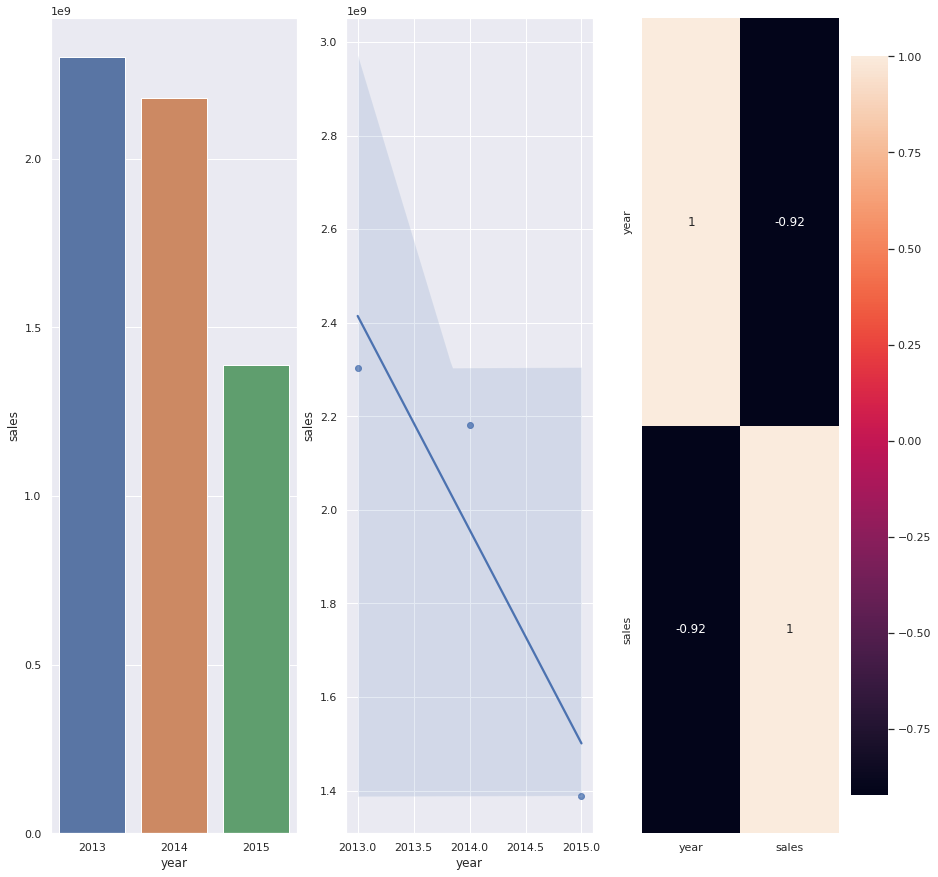

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='year', y='sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='year', y='sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H8. Stores are more likely to sell more more in the second half of the year

In [45]:
# aux1 = df4[['month','sales']].groupby('month').mean().reset_index()

# plt.figure(figsize=(20,8))

# plt.subplot(1,3,1)
# sns.barplot(x='month', y='sales', data=df4, estimator = np.mean, capsize=.1)

# plt.subplot(1,3,2)
# sns.regplot(x='month', y='sales', data=df4, x_estimator=np.mean)
# plt.xlim(0.5, 12.5)
# plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
# plt.xlabel

# plt.subplot(1,3,3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True)
# plt.show()

### H9. Stores are more likely to sell more after the 10th day of each month

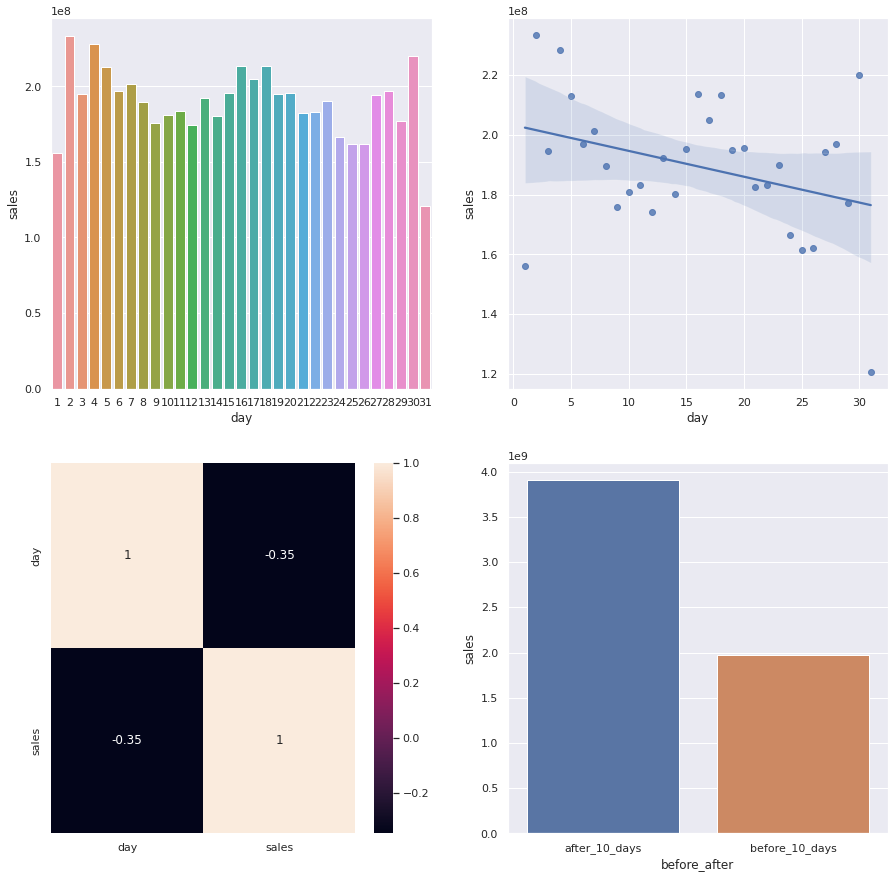

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot(x='day', y='sales', data = aux1)

plt.subplot( 2, 2, 2)
sns.regplot(x='day', y='sales', data = aux1)

plt.subplot( 2, 2, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

plt.subplot( 2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);



### H10. Stores are more likely to sell less on weekends

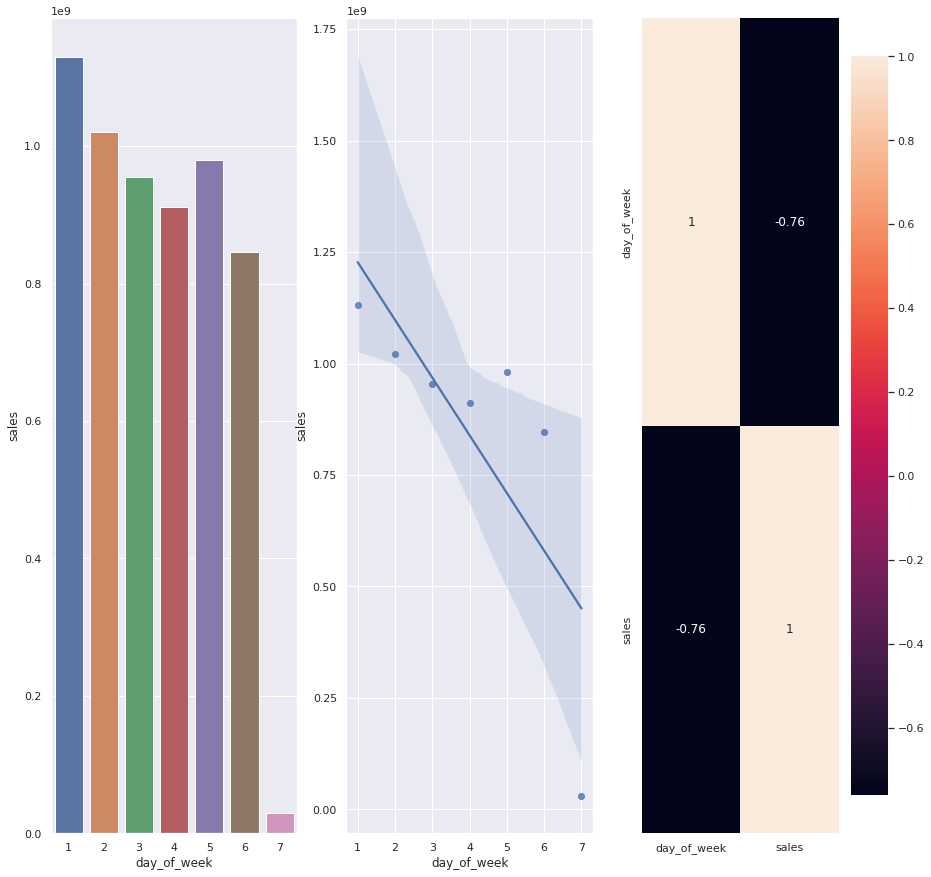

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H11. Stores are more likely to sell less during school holidays

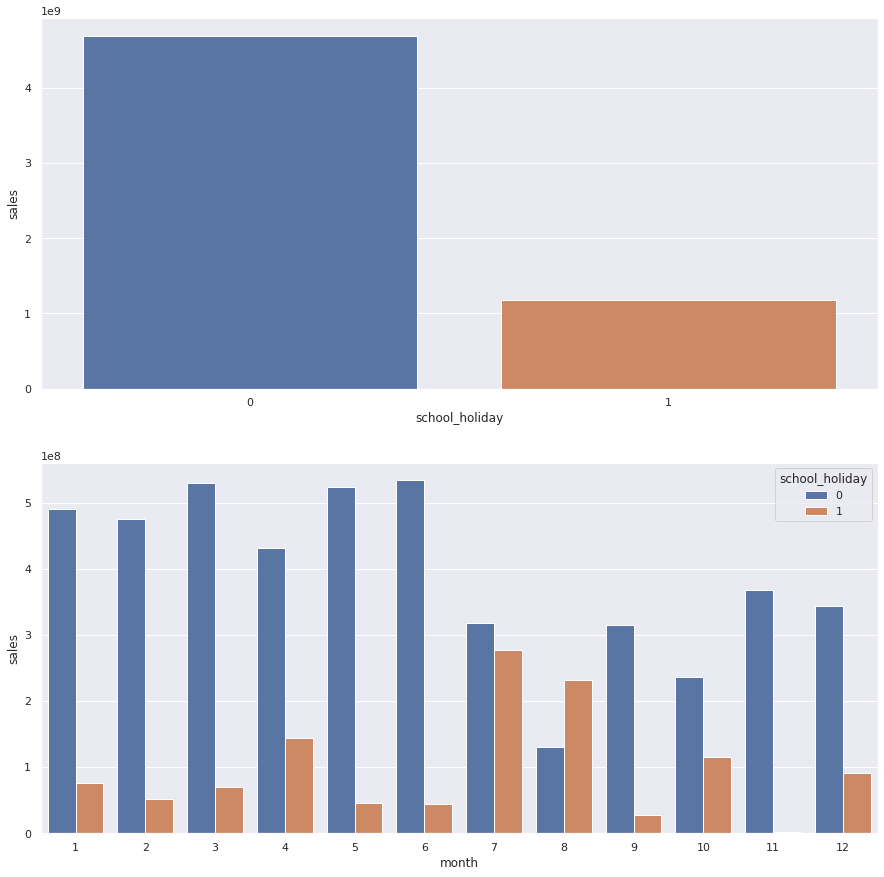

In [48]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);


## Hypothesis Summary 


In [49]:
table = [['Hypotheses', 'Conclusion', 'Relevance'],
        ['H1 - stores with more product assortment are more likely to sell more daily', 'true','medium'],
        ['H2 - stores with closer competitors should are more likely to sell less', 'false','low'],
        ['H3 - stores with longer-standing competitors are more likely sell more','false','medium'],
        ['H4 - products on sales during a long period of time are more likely to sell more daily', 'true','low'],
        ['H5 - stores with more extended promotions should sell more', 'false', 'high'],
        ['H6 - sales are more likely to increase the during holiday season (Christmas)','true', 'high'],
        ['H7 - stores are more likely to sell more over the years', 'inconclusive', 'high*'],
        ['H8 - stores are more likely to sell more more in the second half of the year','false','medium'],
        ['H9 - stores are more likely to sell more after the 10th day of each month', 'false', 'high'],
        ['H10 - stores are more likely to sell less on weekends', 'true', 'high'],
        ['H11 - stores are more likely to sell less during school holidays','false','high']     
        ]

print(tabulate(table, headers='firstrow'))
print("\n*although the H7 was inconclusive, I consider the variable 'year' to be highly relevant for the Machine Learning \n model")

Hypotheses                                                                              Conclusion    Relevance
--------------------------------------------------------------------------------------  ------------  -----------
H1 - stores with more product assortment are more likely to sell more daily             true          medium
H2 - stores with closer competitors should are more likely to sell less                 false         low
H3 - stores with longer-standing competitors are more likely sell more                  false         medium
H4 - products on sales during a long period of time are more likely to sell more daily  true          low
H5 - stores with more extended promotions should sell more                              false         high
H6 - sales are more likely to increase the during holiday season (Christmas)            true          high
H7 - stores are more likely to sell more over the years                                 inconclusive  high*
H8 - stores are more l

## 4.3. Multivariate Analysis


### 4.3.1. Numerical attributes

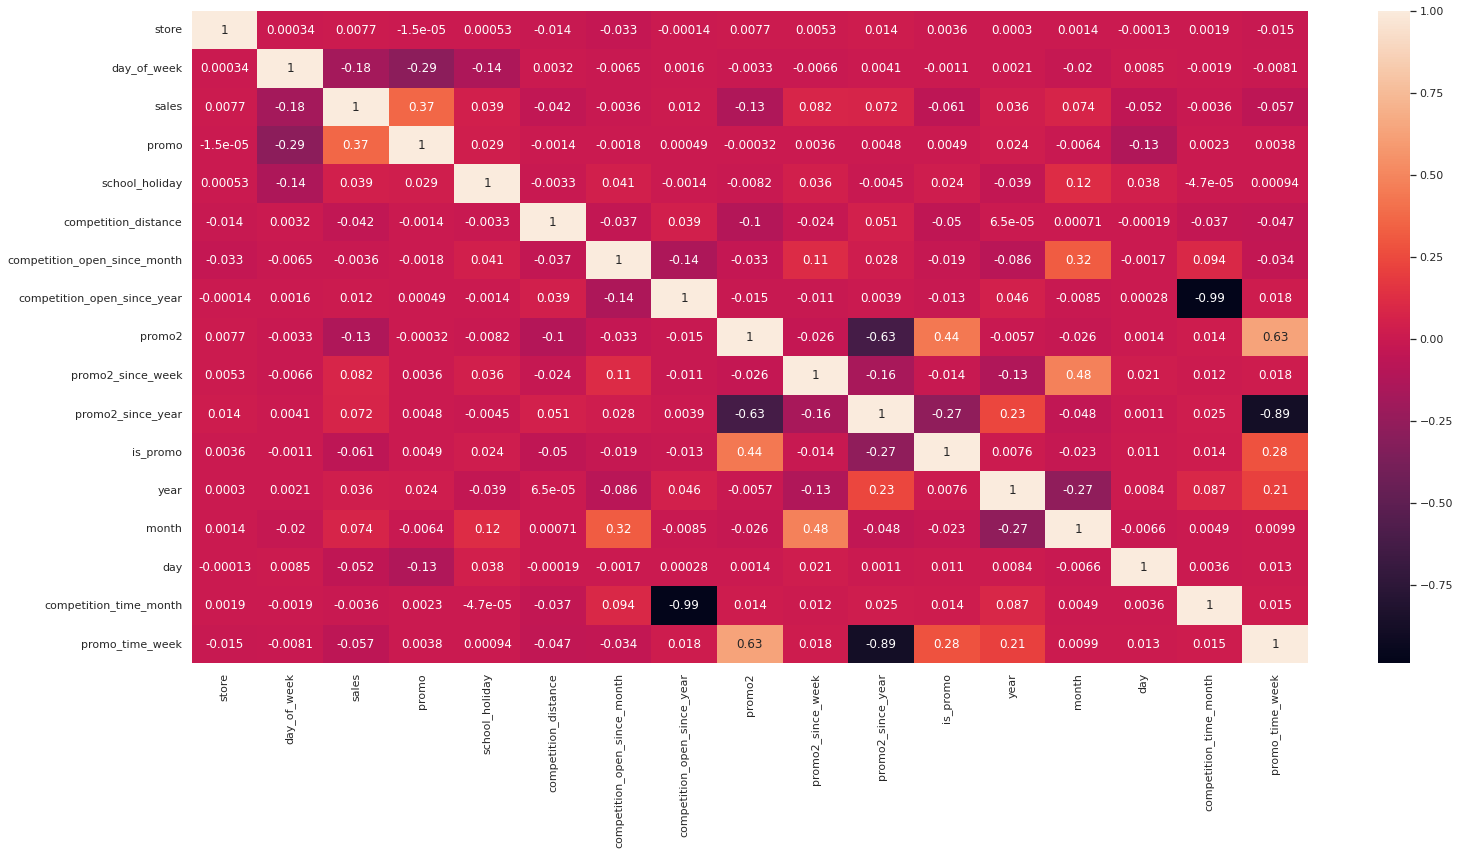

In [50]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(25,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes


In [51]:
# categorical attributes refer to columns of type 'object'
a = df4.select_dtypes( include  = ['object'])


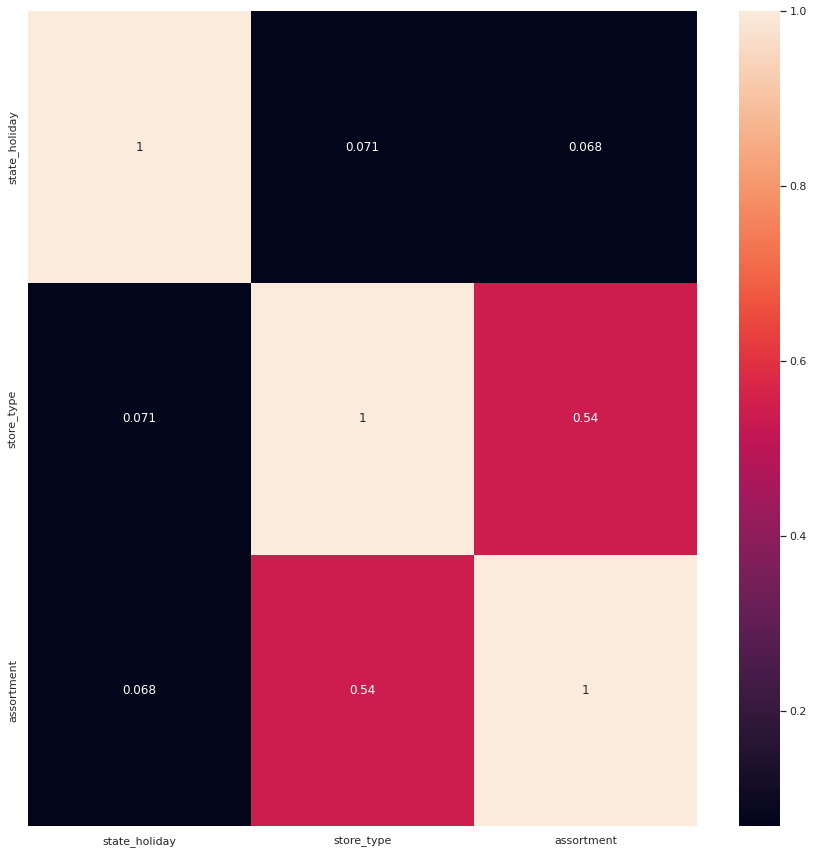

In [52]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#  final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);


# 5.0. Data Preparation

In [53]:
df5 = df4.copy()

## 5.1. Normalization

After consulting section 4.1.2 it is noted that there is no normal distribution. Therefore, normalization (which would be centered on 0 and adjust the standard deviation to 1) will not be applied to any data series.

## 5.2. Rescaling

In [54]:
# converting the 'week_of_year' series from type UInt32 to int64
df5['week_of_year'] = df5['week_of_year'].astype('int64')

The 4 non-cyclical variables where the rescaling will be applied are:

   - 'competition_distance'
   
   - 'year'
   
   - 'competition_time_month'
   
   - 'promo_time_week'

MinMaxScaler will transform each value in the column proportionally within the range [0,1]. RobustScalers is used to minimize the influence of outliers.

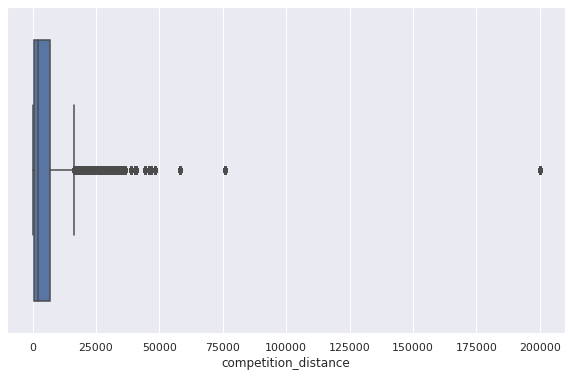

In [55]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

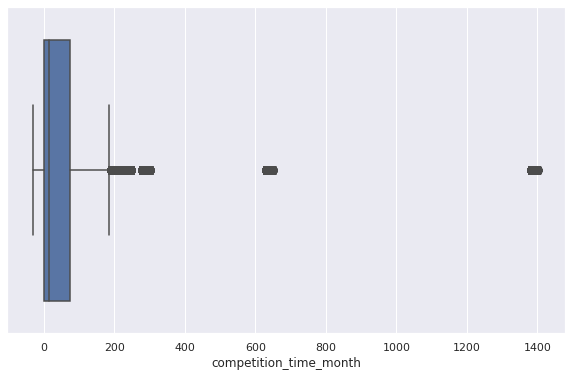

In [56]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

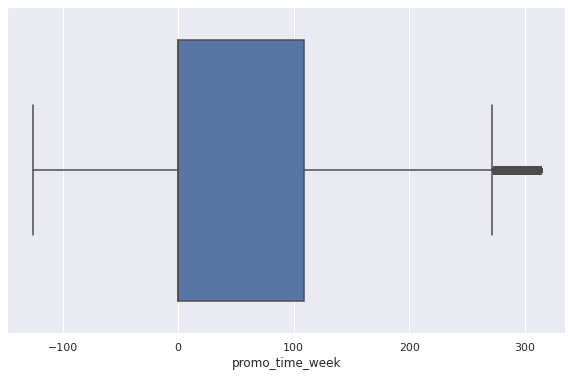

In [57]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

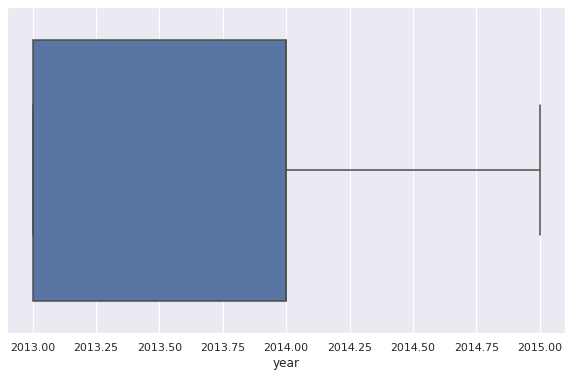

In [58]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl','wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )


## 5.3. Transformation

### 5.3.1. Non-cyclical features encoding


In [60]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Cyclical features encoding

In [61]:
df5['sales'] = np.log1p( df5['sales'])

In [62]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


### 5.3.3. Transformation of the target variable


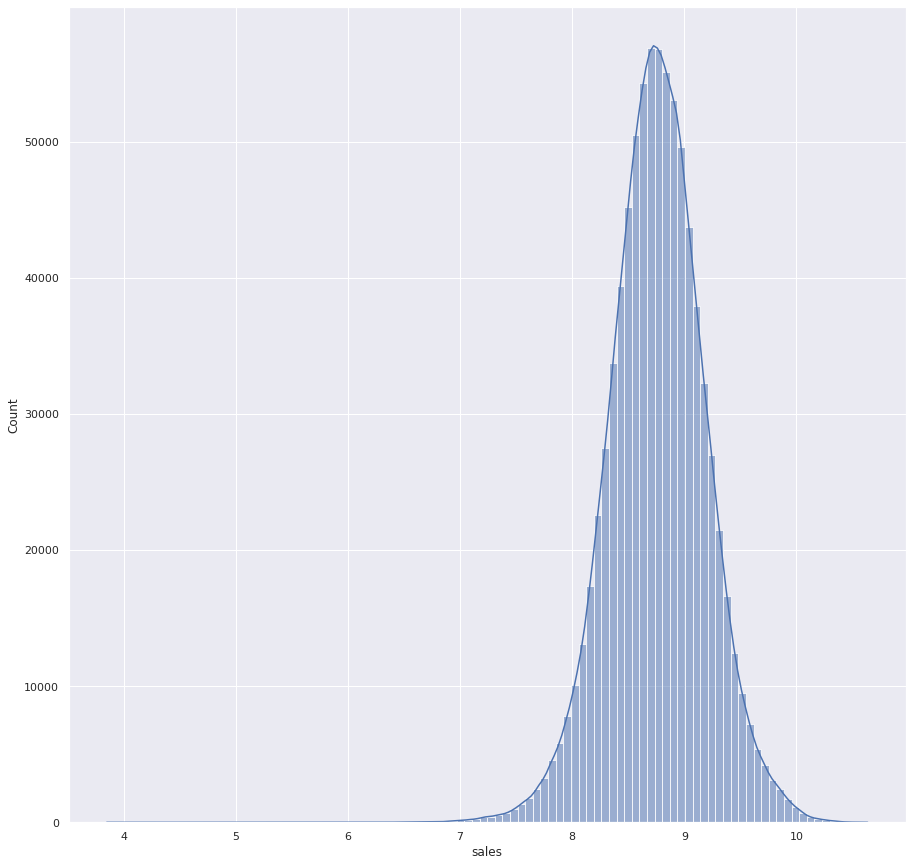

In [64]:
sns.histplot(x = df5['sales'],bins=100,kde = True);

# 6.0. Feature Selection

In [65]:
df6 = df5.copy()
# delete features that were already used to create others but are now no longer important
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

## 6.1 Split dataframe into training and test dataset 

In [66]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [67]:
df6[['store','date']].groupby('store').min().reset_index()['date'][0]
df6[['store','date']].groupby('store').max().reset_index()['date'][0]
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [68]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print("Training min date: {}".format(X_train['date'].min()))
print("Training max date: {}".format(X_train['date'].max()))

print(f"\nTest min date: {X_test['date'].min()}")
print(f"Test max date: {X_test['date'].max()}")

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [69]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )
# #cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # columns not selected 
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [70]:
cols_not_selected_boruta = [
    'is_promo',
    'month_sin', 
    'school_holiday', 
    'state_holiday_christmas', 
    'state_holiday_easter_holiday',                            
    'state_holiday_public_holiday', 
    'state_holiday_regular_day', 
    'week_of_year_sin', 
    'year']

# add 'month_sin' and 'week_of_year_sin' (initially Boruta left both out)

cols_selected_boruta = [
    'store',
    'promo', 
    'store_type', 
    'assortment', 
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year', 
    'promo2', 
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week', 
    'month_cos',
    'month_sin',
    'day_sin', 
    'day_cos', 
    'week_of_year_cos', 
    'day_of_week_sin', 
    'day_of_week_cos',
    'week_of_year_sin']

# columns to add
feat_to_add = ['sales','date']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. Machine Learning Modelling

In [71]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full]


## 7.1. Average Model


In [72]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [73]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [74]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv

## 7.3. Regularized Linear Regression Model

In [75]:
# model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1. Lasso - Cross Validation

In [76]:
# lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
# lrr_result_cv

## 7.4. Random Forest Regressor

In [77]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42, max_depth=6 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1818.381168,0.273233,2606.352567


### 7.4.1. Random Forest Regressor - Cross Validation

In [78]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5. XGBoost Regressor

In [79]:
# model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=50,
#                               eta=0.01,
#                               max_depth=10,
#                               subsample=0.7,
#                               colsample_bytee=0.9 ).fit( x_train, y_train )

model_xgb = xgb.XGBRegressor( max_depth=10).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,678.441469,0.098479,992.42493


### 7.5.1. XBBoost Regressor - Cross Validation

In [80]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv

## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance 

In [81]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation

In [82]:
# modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv ,rf_result_cv, xgb_result_cv] )
# modelling_result_cv.sort_values( 'RMSE CV' )

# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

In [83]:
# param = {
#         'n_estimators': [100, 150, 200, 250, 300], 
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 5

In [84]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # escolha os valores dos parâmetros aleatoriamente
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(
#                                 objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight']
#                                 )

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2. Final Model

In [85]:
# # Recebe os parâmetros de melhor desempenho descobertos pelo Random Search
# param_tuned = {
#         'n_estimators': 300, 
#         'eta': 0.03,
#         'max_depth': 9,
#         'subsample': 0.5,
#         'colsample_bytree': 0.7,
#         'min_child_weight': 3
#         }

In [86]:
# # model
# model_xgb_tuned = xgb.XGBRegressor(
#                             objective='reg:squarederror',
#                             n_estimators=param_tuned['n_estimators'],
#                             eta=param_tuned['eta'],
#                             max_depth=param_tuned['max_depth'],
#                             subsample=param_tuned['subsample'],
#                             colsample_bytree=param_tuned['colsample_bytree'],
#                             min_child_weight=param_tuned['min_child_weight']
#                             ).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # performance
# result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# result

## 8.2. Saving the Final Model

In [87]:
# saving so I do not need to train the model again
# pickle.dump(model_xgb_tuned, open('/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'wb'))

In [88]:
# to load the template
model_xgb_tuned = pickle.load(open('/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'rb'))

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost regressor,1043.052811,0.151989,1538.875819


In [89]:
mpe = mean_percentage_error( np.expm1 (y_test), np.expm1( yhat_xgb_tuned))
mpe
# negative mpe means the model is overastimating the sales predictions

-0.012602197297704405

# 9.0. Performance

In [90]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [91]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [92]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
285,286,212015.937500,209973.533790,214058.341210,2042.403710,0.698051
291,292,116274.828125,112688.426347,119861.229903,3586.401778,0.686517
487,488,226811.718750,224418.618362,229204.819138,2393.100388,0.656174
424,425,180085.875000,178382.472828,181789.277172,1703.402172,0.579679
472,473,186603.250000,184839.162235,188367.337765,1764.087765,0.575873


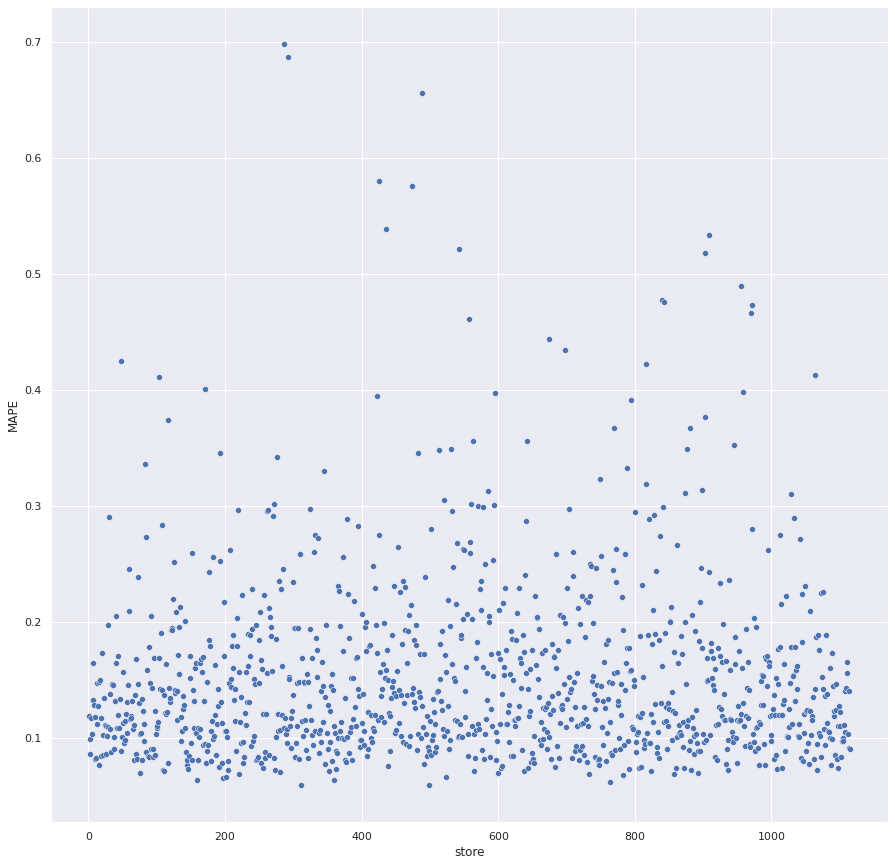

In [93]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [94]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"$276,838,720.00"
1,worst_scenario,"$275,673,371.61"
2,best_scenario,"$278,004,055.47"


## 9.3. Machine Learning Performance


In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

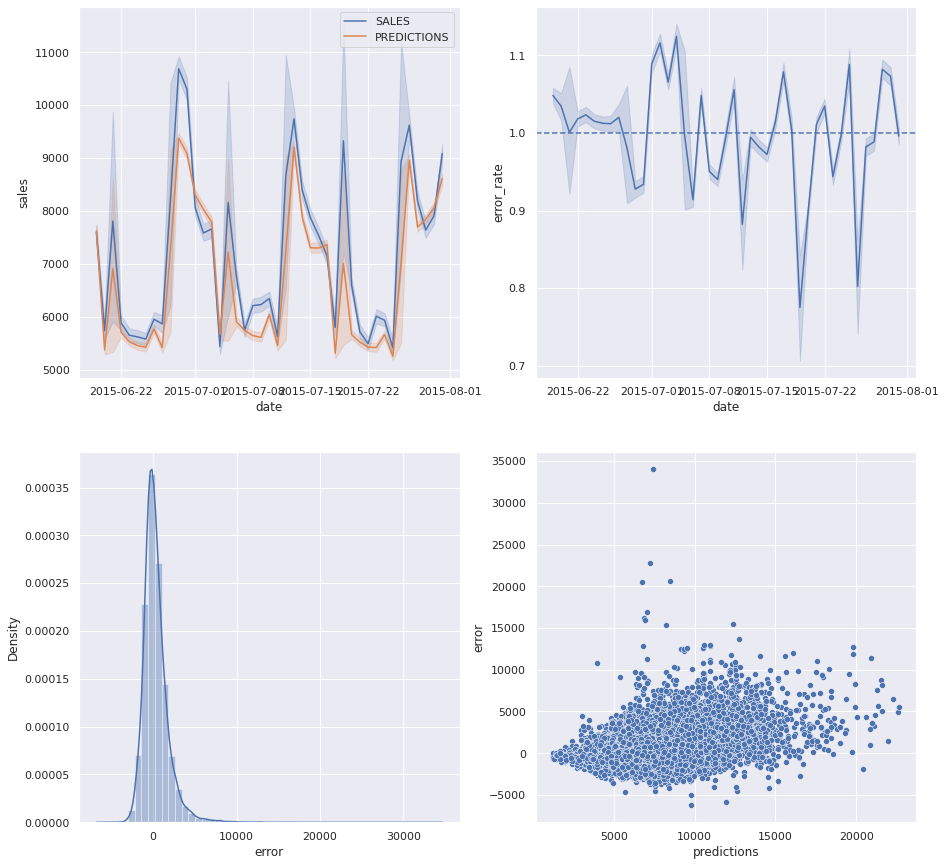

In [96]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. Deploy Model to Production

## 10.1. Rossmann Class

In [103]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/rafael/Repos/rossmann_sales_prediction/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )


    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)


        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)

        #promo_interval
        month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                              1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                              0, axis = 1 )

        ## 1.6. Change Data Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        
        return df1
    
    
    def feature_engineering( self, df2 ):
        
        # year
        df2 ['year'] = df2['date'].dt.year

        # month
        df2 ['month'] = df2['date'].dt.month

        # day
        df2 ['day'] = df2['date'].dt.day

        # week of year
        df2 ['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' 
                                                          else 'easter_holiday' if  x=='b'  
                                                          else 'christmas' if x == 'c'
                                                          else 'regular_day')
        
       
        # Filtering  Variables
        
        # df3 = df3.loc[df3['open'] == 1]
        df2 = df2[(df2['open'] != 0)]
        
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
    
        # converting the 'week_of_year' series from type UInt32 to int64
        df5['week_of_year'] = df5['week_of_year'].astype('int64')


        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)


        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding

        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                                'competition_open_since_month','competition_open_since_year', 'promo2', 
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                'promo_time_week', 'month_cos','month_sin','day_sin', 'day_cos', 
                                'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos','week_of_year_sin']
        
        return df5 [cols_selected]

    def get_prediction ( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [104]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )
                          
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
            
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
            
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
            
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
            
        # data preparation
        df3 = pipeline.data_preparation( df2 )
            
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
            
        return df_response
        
        
    else:
        
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' ) # '0.0.0.0' indicates that this Flask application is running locally so I can run the simulation.

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [111]:
import requests
import json

In [108]:
# loading test dataset
df10 = pd.read_csv( '/home/rafael/Repos/rossmann_sales_prediction/rossmann-store-sales/test.csv' )

In [109]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [112]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [113]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
# url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [115]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys())

In [117]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$289,578.07 in the next 6 weeks
Store Number 22 will sell R$192,504.19 in the next 6 weeks
Store Number 23 will sell R$244,426.86 in the next 6 weeks
